Exploration vs exploitation

Sigurd Carlen, September 2019.

In [1]:
import numpy as np
np.random.seed(1234)

%matplotlib inline
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

<Figure size 432x288 with 0 Axes>

We can control how much the  acqusition function favors exploration and exploitation by tweaking the two parameters kappa and xi. Higher values means more exploration and less exploitation and vice versa with low values.

kappa is only used if acq_func is set to "LCB". xi is used when acq_func is "EI" or "PI". By default the acqusition function is set to "gp_hedge" which chooses the best of these three. Therefore I recommend not using gp_hedge when tweaking exploration/exploitation, but instead choosing "LCB", "EI" or "PI.

The way to pass kappa and xi to the optimizer is to use the named argument "acq_func_kwargs". This is a dict of extra arguments for the aqcuisittion function.

If you want opt.ask() to give a new acquisition value imdediatly after tweaking kappa or xi call opt.update_next().
This ensures that the next value is updated with the new acquisition parameters.

## The Setup

First we define our objective like in the ask-and-tell example notebook and define a plotting function. We do however only use on initial random point. All points afterthe first one is therefore choosen by the acquisition function.

In [2]:
from ProcessOptimizer.learning import ExtraTreesRegressor
from ProcessOptimizer import Optimizer

noise_level = 0.1

# Our 1D toy problem, this is the function we are trying to
# minimize
def objective(x, noise_level=noise_level):
    return np.sin(5 * x[0]) * (1 - np.tanh(x[0] ** 2)) + np.random.randn() * noise_level

In [3]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1, acq_optimizer="sampling")

In [4]:
x = np.linspace(-2, 2, 400).reshape(-1, 1)
fx = np.array([objective(x_i, noise_level=0.0) for x_i in x])

In [5]:
from ProcessOptimizer.acquisition import gaussian_ei

def plot_optimizer(opt, x, fx):
    model = opt.models[-1]
    x_model = opt.space.transform(x.tolist())

    # Plot true function.
    plt.plot(x, fx, "r--", label="True (unknown)")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([fx - 1.9600 * noise_level, 
                             fx[::-1] + 1.9600 * noise_level]),
             alpha=.2, fc="r", ec="None")

    # Plot Model(x) + contours
    y_pred, sigma = model.predict(x_model, return_std=True)
    plt.plot(x, y_pred, "g--", label=r"$\mu(x)$")
    plt.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma, 
                             (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.2, fc="g", ec="None")

    # Plot sampled points
    plt.plot(opt.Xi, opt.yi,
             "r.", markersize=8, label="Observations")

    acq = gaussian_ei(x_model, model, y_opt=np.min(opt.yi))
    # shift down to make a better plot
    acq = 4*acq - 2
    plt.plot(x, acq, "b", label="EI(x)")
    plt.fill_between(x.ravel(), -2.0, acq.ravel(), alpha=0.3, color='blue')
    
    # Adjust plot layout
    plt.grid()
    plt.legend(loc='best')


We run a an optimization loop with standard settings

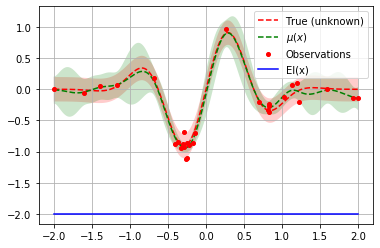

In [6]:
for i in range(30):
    next_x = opt.ask()
    f_val = objective(next_x)
    opt.tell(next_x, f_val)
plot_optimizer(opt, x, fx)

We see that some minima is found and "exploited"

Now lets try to set kappa and xi using'to other values and pass it to the optimizer:

In [7]:
acq_func_kwargs={"xi":10000,"kappa":10000}

In [8]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1, acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

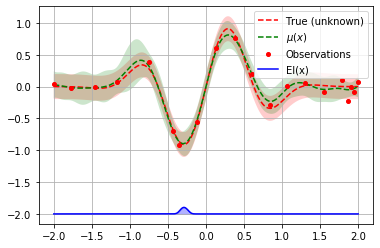

In [9]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

We see that the points are more random now.

This works both for kappa when using acq_func="LCB":

In [10]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="LCB", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

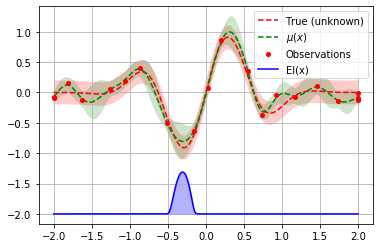

In [11]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

And for xi when using acq_func="EI": or acq_func="PI":

In [12]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="PI", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

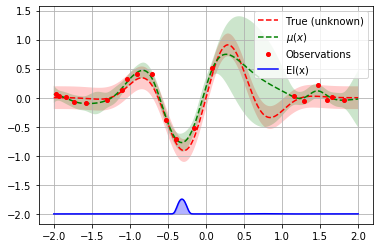

In [13]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

We can also favor exploitaton:

In [14]:
acq_func_kwargs={"xi":0.000001,"kappa":0.001}

In [15]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="LCB", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

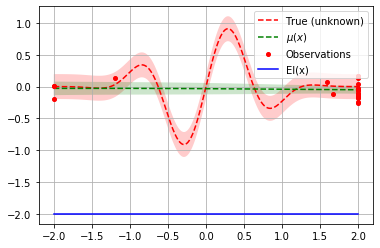

In [16]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

In [17]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="EI", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

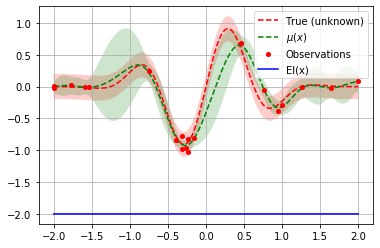

In [18]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

In [19]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="PI", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

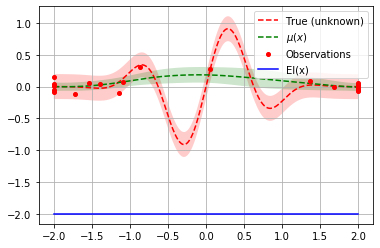

In [20]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

Note that negative values deos not work with the "PI"-acquisition function but works with "EI":

In [21]:
acq_func_kwargs={"xi":-1000000000000}

In [22]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="PI", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

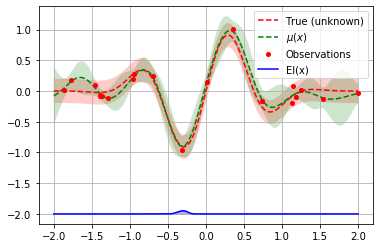

In [23]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

In [24]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="EI", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

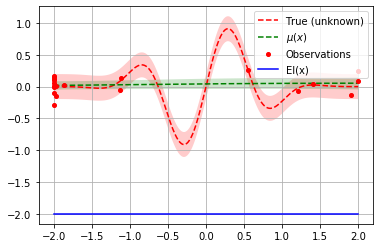

In [25]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

## Changing kappa and xi on the go

If we want to change kappa or ki at any point during our optimization process we just replace opt.acq_func_kwargs

In [26]:
acq_func_kwargs={"kappa":0}

In [27]:
opt = Optimizer([(-2.0, 2.0)], "GP", n_initial_points = 1,acq_func="LCB", acq_optimizer="sampling",acq_func_kwargs=acq_func_kwargs) 

In [28]:
opt.acq_func_kwargs

{'kappa': 0}

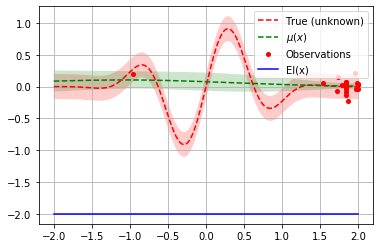

In [29]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)

In [30]:
acq_func_kwargs={"kappa":100000}

In [31]:
opt.acq_func_kwargs = acq_func_kwargs
opt.update_next()

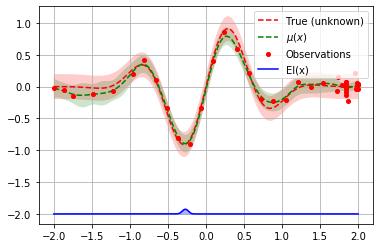

In [32]:
for i in range(20):
    next_x = opt.ask()
    f_val = objective(next_x)
    a = opt.tell(next_x, f_val)
    
plot_optimizer(opt, x, fx)